# Import 

In [1]:
import os
import re
import sys
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
from skimage import io
from sklearn import preprocessing
from tqdm.notebook import tqdm, trange
import anndata as ad
import cv2
import pickle
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics import mean_squared_error

In [2]:
d_dir = (Path().cwd().parents[0].parents[0]).absolute()
data_dir = d_dir / "09_datasets"

p_dir = (Path().cwd().parents[0]).absolute()

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


In [4]:
import morph
mask_folder = data_dir / 'exported' / 'foll_masks'

In [5]:
import math

def plot(data, ax, N=100, concat=False,**kwargs):
    if concat:
        x = np.concatenate([data[:N], [data[0]]])
        y = np.concatenate([data[N:], [data[N]]])
    else:
        x = data[1]
        y = data[0]
        x = np.append(x, x[0])
        y = np.append(y, y[0])
    ax.plot(x, y, linewidth=2, **kwargs)
    ax.set_aspect('equal')
    # ax.axis('off')

def plot_point(point, angle, length, ax):
    '''
    point - Tuple (x, y)
    angle - Angle you want your end point at in degrees.
    length - Length of the line you want to plot.

    Will plot the line on a 10 x 10 plot.
    '''

    # unpack the first point
    x, y = point

    # find the end point
    endy = y + length * math.sin(angle)
    endx = x + length * math.cos(angle)

    # plot the points
    ax.plot([x, endx], [y, endy])

def reshape(data, N=100):
    return np.stack([data[:N], data[N:]]).T

# Read MorphPCA model

In [6]:
# Load extracted foll and gc contours 
foll_data_path = mask_folder / 'foll.npz'
gc_data_path = mask_folder / 'gc.npz'

data_path = p_dir / 'data' / 'morph' / 'morph_data.pkl'

if data_path.exists():
    print('Loaded existing file.')
    morph_data = morph.MORPH.load(data_path)
else:
    # Create MORPH data object
    morph_data = morph.MORPH(mask_folder, foll_data_path, gc_data_path)

    # Extract boundaries
    morph_data.load_boundaries()

    morph_data.resample_boundaries()
    morph_data.save_pickle(data_path)

Loaded existing file.


In [7]:
save_path = p_dir / 'data' / 'morph' / 'outlinePCA.pkl'

outlinePCA = morph.OutlinePCA.load(save_path)

In [8]:
outlinePCA.__dict__.keys()

dict_keys(['gc_one_hot', 'bd_reg_foll', 'bd_reg_gc', 'df_foll_info', 'df', 'morph_data', 'foll_pca', 'gc_pca', 'foll_weights', 'gc_weights', 'latent_folls', 'latent_gcs', 'inverse_pca_foll', 'inverse_pca_gc', 'df_weights'])

In [9]:
len(outlinePCA.inverse_pca_foll)

1007

In [10]:
N = 120
h_distance_foll_pca = []
h_distance_gc_pca = []

for i in range(len(outlinePCA.inverse_pca_foll)):
    # Compute Hausdorff distance
    h_distance_foll_pca.append(
        max(directed_hausdorff(
                reshape(outlinePCA.inverse_pca_foll[i], N=N), 
                reshape(outlinePCA.bd_reg_foll[i], N=N)
            )[0],
            directed_hausdorff(
                reshape(outlinePCA.bd_reg_foll[i], N=N),
                reshape(outlinePCA.inverse_pca_foll[i], N=N), 
            )[0]
        )
    )
            
    # Compute Hausdorff distance
    h_distance_gc_pca.append(
        max(directed_hausdorff(
                reshape(outlinePCA.gc_one_hot[i, np.newaxis]*outlinePCA.inverse_pca_gc[i], N=N), 
                reshape(outlinePCA.gc_one_hot[i, np.newaxis]*outlinePCA.bd_reg_gc[i], N=N)
            )[0],
            directed_hausdorff(
                reshape(outlinePCA.gc_one_hot[i, np.newaxis]*outlinePCA.bd_reg_gc[i], N=N),
                reshape(outlinePCA.gc_one_hot[i, np.newaxis]*outlinePCA.inverse_pca_gc[i], N=N), 
            )[0],
        )
    )

In [11]:
mse_foll_pca = []
mse_gc_pca = []

for i in range(len(outlinePCA.inverse_pca_foll)):
    # Compute Hausdorff distance
    mse_foll_pca.append(
        mean_squared_error(
                reshape(outlinePCA.inverse_pca_foll[i], N=N), 
                reshape(outlinePCA.bd_reg_foll[i], N=N)
            )
    )
            
    # Compute Hausdorff distance
    mse_gc_pca.append(
        mean_squared_error(
                reshape(outlinePCA.gc_one_hot[i, np.newaxis]*outlinePCA.inverse_pca_gc[i], N=N), 
                reshape(outlinePCA.gc_one_hot[i, np.newaxis]*outlinePCA.bd_reg_gc[i], N=N)
            )
    )

In [12]:
# N = 120
# N_rows = 10
# N_cols = 10
# figsize = (10,10)

# ## Reconstruction
# fig, axes = plt.subplots(N_rows, N_cols, figsize=figsize, sharey=True, sharex=True)
# for i, row in enumerate(axes):
#     for j in range(len(row)):
#         # plot(outlinePCA.bd_reg_foll[i*N_rows+j], row[j], N=N, color='r', alpha=0.8, concat=True)
#         plot(outlinePCA.inverse_pca_foll[i*N_rows+j], row[j], N=N, color='m', ls='--', concat=True)
#         if outlinePCA.gc_one_hot[i*N_rows+j] == 1:
#             # plot(outlinePCA.bd_reg_gc[i*N_rows+j], row[j], N=N, color='b', alpha=0.8, concat=True)
#             plot(outlinePCA.inverse_pca_gc[i*N_rows+j], row[j], N=N, color='c', ls='--', concat=True)
# plt.tight_layout(rect=[0, 0.03, 1, 0.90])
# plt.subplots_adjust(wspace=0, hspace=0)

# Create Autoencoder model

In [13]:
import morphAE 

In [14]:
print(outlinePCA.__dict__.keys())

dict_keys(['gc_one_hot', 'bd_reg_foll', 'bd_reg_gc', 'df_foll_info', 'df', 'morph_data', 'foll_pca', 'gc_pca', 'foll_weights', 'gc_weights', 'latent_folls', 'latent_gcs', 'inverse_pca_foll', 'inverse_pca_gc', 'df_weights'])


In [39]:
foll_weights, foll_predict, foll_ae = morphAE.tl.AE_emb(outlinePCA.bd_reg_foll, epochs=200)

GPU name:  []
Epoch 1/200
32/32 - 1s - reconstruction_loss: 0.2825
Epoch 2/200
32/32 - 0s - reconstruction_loss: 0.0190
Epoch 3/200
32/32 - 0s - reconstruction_loss: 0.0078
Epoch 4/200
32/32 - 0s - reconstruction_loss: 0.0075
Epoch 5/200
32/32 - 0s - reconstruction_loss: 0.0074
Epoch 6/200
32/32 - 0s - reconstruction_loss: 0.0074
Epoch 7/200
32/32 - 0s - reconstruction_loss: 0.0072
Epoch 8/200
32/32 - 0s - reconstruction_loss: 0.0062
Epoch 9/200
32/32 - 0s - reconstruction_loss: 0.0046
Epoch 10/200
32/32 - 0s - reconstruction_loss: 0.0038
Epoch 11/200
32/32 - 0s - reconstruction_loss: 0.0037
Epoch 12/200
32/32 - 0s - reconstruction_loss: 0.0036
Epoch 13/200
32/32 - 0s - reconstruction_loss: 0.0036
Epoch 14/200
32/32 - 0s - reconstruction_loss: 0.0036
Epoch 15/200
32/32 - 0s - reconstruction_loss: 0.0035
Epoch 16/200
32/32 - 0s - reconstruction_loss: 0.0034
Epoch 17/200
32/32 - 0s - reconstruction_loss: 0.0033
Epoch 18/200
32/32 - 0s - reconstruction_loss: 0.0031
Epoch 19/200
32/32 - 0s

In [40]:
gc_weights, gc_predict, gc_ae = morphAE.tl.AE_emb(outlinePCA.bd_reg_gc, epochs=200)
gc_predict = outlinePCA.gc_one_hot[:, np.newaxis]*gc_predict

GPU name:  []
Epoch 1/200
32/32 - 1s - reconstruction_loss: 0.1509
Epoch 2/200
32/32 - 0s - reconstruction_loss: 0.0398
Epoch 3/200
32/32 - 0s - reconstruction_loss: 0.0270
Epoch 4/200
32/32 - 0s - reconstruction_loss: 0.0184
Epoch 5/200
32/32 - 0s - reconstruction_loss: 0.0128
Epoch 6/200
32/32 - 0s - reconstruction_loss: 0.0090
Epoch 7/200
32/32 - 0s - reconstruction_loss: 0.0060
Epoch 8/200
32/32 - 0s - reconstruction_loss: 0.0048
Epoch 9/200
32/32 - 0s - reconstruction_loss: 0.0038
Epoch 10/200
32/32 - 0s - reconstruction_loss: 0.0029
Epoch 11/200
32/32 - 0s - reconstruction_loss: 0.0026
Epoch 12/200
32/32 - 0s - reconstruction_loss: 0.0025
Epoch 13/200
32/32 - 0s - reconstruction_loss: 0.0024
Epoch 14/200
32/32 - 0s - reconstruction_loss: 0.0024
Epoch 15/200
32/32 - 0s - reconstruction_loss: 0.0024
Epoch 16/200
32/32 - 0s - reconstruction_loss: 0.0024
Epoch 17/200
32/32 - 0s - reconstruction_loss: 0.0023
Epoch 18/200
32/32 - 0s - reconstruction_loss: 0.0023
Epoch 19/200
32/32 - 0s

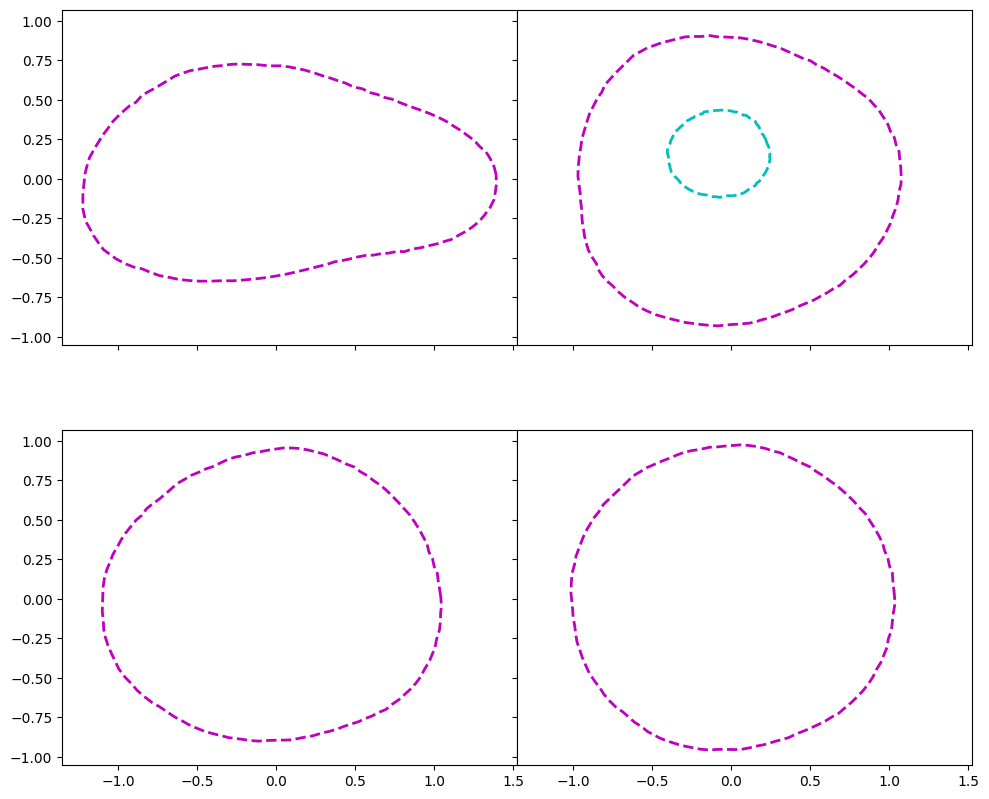

In [41]:
N = 120
N_rows = 2
N_cols = 2
figsize = (10,10)

## Reconstruction
fig, axes = plt.subplots(N_rows, N_cols, figsize=figsize, sharey=True, sharex=True)
for i, row in enumerate(axes):
    for j in range(len(row)):
        # plot(outlinePCA.bd_reg_foll[i*N_rows+j], row[j], N=N, color='r', alpha=0.8, concat=True)
        plot(foll_predict[i*N_rows+j], row[j], N=N, color='m', ls='--', concat=True)
        if outlinePCA.gc_one_hot[i*N_rows+j] == 1:
            # plot(outlinePCA.bd_reg_gc[i*N_rows+j], row[j], N=N, color='b', alpha=0.8, concat=True)
            plot(gc_predict[i*N_rows+j], row[j], N=N, color='c', ls='--', concat=True)
plt.tight_layout(rect=[0, 0.03, 1, 0.90])
plt.subplots_adjust(wspace=0, hspace=0)

In [42]:
h_distance_foll_ae = []
h_distance_gc_ae = []

for i in range(len(foll_predict)):
    # Compute Hausdorff distance
    h_distance_foll_ae.append(
        max(directed_hausdorff(
                reshape(foll_predict[i], N=N), 
                reshape(outlinePCA.bd_reg_foll[i], N=N)
            )[0],
            directed_hausdorff(
                reshape(outlinePCA.bd_reg_foll[i], N=N),
                reshape(foll_predict[i], N=N), 
            )[0]
        )
    )
            
    # Compute Hausdorff distance
    h_distance_gc_ae.append(
        max(directed_hausdorff(
                reshape(gc_predict[i], N=N), 
                reshape(outlinePCA.gc_one_hot[i, np.newaxis]*outlinePCA.bd_reg_gc[i], N=N)
            )[0],
            directed_hausdorff(
                reshape(outlinePCA.gc_one_hot[i, np.newaxis]*outlinePCA.bd_reg_gc[i], N=N),
                reshape(gc_predict[i], N=N), 
            )[0],
        )    
    )

In [43]:
mse_foll_ae = []
mse_gc_ae = []

for i in range(len(foll_predict)):
    # Compute Hausdorff distance
    mse_foll_ae.append(
        mean_squared_error(
                reshape(foll_predict[i], N=N), 
                reshape(outlinePCA.bd_reg_foll[i], N=N)
            )
    )
            
    # Compute Hausdorff distance
    mse_gc_ae.append(
        mean_squared_error(
                reshape(gc_predict[i], N=N), 
                reshape(outlinePCA.gc_one_hot[i, np.newaxis]*outlinePCA.bd_reg_gc[i], N=N)
            )
    )

# Compare Hausdorff distance

In [44]:
import seaborn as sns
from statannotations.Annotator import Annotator


In [45]:
df = pd.DataFrame({'Follicle PCA': h_distance_foll_pca, 'GC PCA': h_distance_foll_pca,
                    'Follicle AE': h_distance_foll_ae, 'GC AE': h_distance_foll_ae})
df_melt = df.melt(var_name='Method', value_name='Hausdorff Distance')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Follicle PCA vs. Follicle AE: Mann-Whitney-Wilcoxon test two-sided, P_val:5.429e-24 U_stat=3.752e+05
GC PCA vs. GC AE: Mann-Whitney-Wilcoxon test two-sided, P_val:5.429e-24 U_stat=3.752e+05


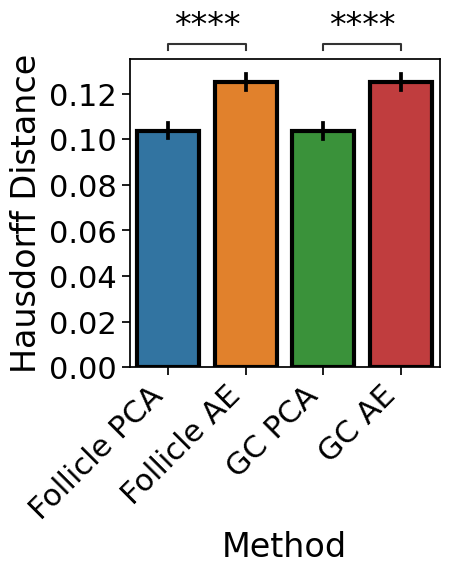

In [46]:
x = 'Method'
y = 'Hausdorff Distance'

pairs=[('Follicle PCA', 'Follicle AE'), ('GC PCA', 'GC AE')]

with sns.plotting_context('notebook', font_scale=2):
    fig, ax = plt.subplots(figsize=(4,4))
    sns.barplot(data=df_melt, x=x, y=y, ax=ax, order=['Follicle PCA', 'Follicle AE', 'GC PCA', 'GC AE'], edgecolor=".0", linewidth=3, errcolor=".0")
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    annotator = Annotator(ax, pairs, data=df_melt, x=x, y=y, order=['Follicle PCA', 'Follicle AE', 'GC PCA', 'GC AE'])
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()

In [47]:
df = pd.DataFrame({'Follicle PCA': mse_foll_pca, 'GC PCA': mse_foll_pca,
                    'Follicle AE': mse_foll_ae, 'GC AE': mse_foll_ae})
df_melt = df.melt(var_name='Method', value_name='Mean Squarred Error')

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Follicle PCA vs. Follicle AE: Mann-Whitney-Wilcoxon test two-sided, P_val:2.672e-146 U_stat=1.709e+05
GC PCA vs. GC AE: Mann-Whitney-Wilcoxon test two-sided, P_val:2.672e-146 U_stat=1.709e+05


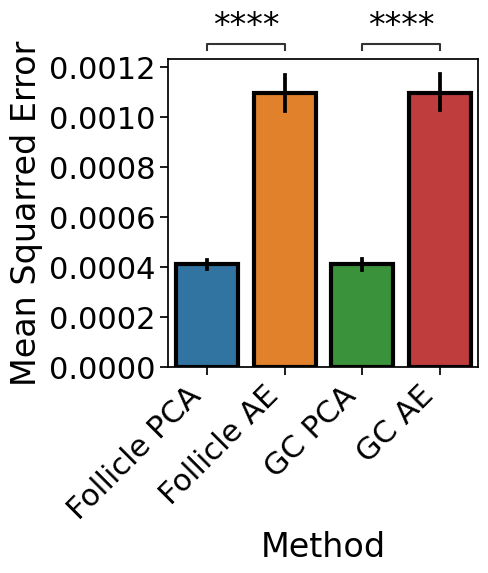

In [48]:
x = 'Method'
y = 'Mean Squarred Error'

pairs=[('Follicle PCA', 'Follicle AE'), ('GC PCA', 'GC AE')]

with sns.plotting_context('notebook', font_scale=2):
    fig, ax = plt.subplots(figsize=(4,4))
    sns.barplot(data=df_melt, x=x, y=y, ax=ax, order=['Follicle PCA', 'Follicle AE', 'GC PCA', 'GC AE'], edgecolor=".0", linewidth=3, errcolor=".0")
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    annotator = Annotator(ax, pairs, data=df_melt, x=x, y=y, order=['Follicle PCA', 'Follicle AE', 'GC PCA', 'GC AE'])
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()